In [ ]:
import tensorflow as tf
from tensorflow.nn import softmax
import numpy as np
from tensorflow.keras.layers import Layer, RNN, Dense,LSTM
from tensorflow.keras import Input,Sequential
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
class Regime(Layer):

  def __init__(self, units,n_models=None):
      super(Regime, self).__init__()
      self.units = units
      self.n_models = n_models
      self.models = []
      for i in range(n_models):
          model = LSTM(units,return_sequences=True,stateful=True)
          setattr(Regime, f'model{i}', model)
          self.models.append(model)

  def call(self, inputs):
      out_states = tf.stack([model(inputs) for model in self.models])
      new_state = tf.keras.activations.tanh(tf.math.reduce_mean(out_states, axis=0))
      return new_state

In [ ]:
df = pd.read_csv('/content/DJI.csv',usecols=['formatted_date','volume','adjclose'],parse_dates=['formatted_date'],infer_datetime_format=True)
df['rate'] = df['adjclose'].pct_change()
df['target'] = np.insert(df['adjclose'].values[1:], -1, df['adjclose'].values[-1])
df.fillna(method='backfill',inplace=True)
df.head()

,formatted_date,volume,adjclose,rate,target
0,1992-01-02,23550000,3172.4,0.009173,3201.5
1,1992-01-03,23620000,3201.5,0.009173,3200.1
2,1992-01-06,27280000,3200.1,-0.000437,3204.8
3,1992-01-07,25510000,3204.8,0.001469,3203.9
4,1992-01-08,29040000,3203.9,-0.000281,3209.5


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
df['adjclose'] = scaler.fit_transform(df['adjclose'].values.reshape(-1,1))
df['target'] = scaler.transform(df['target'].values.reshape(-1,1))

transformer = RobustScaler().fit(df['volume'].values.reshape(-1,1))
df['volume'] = transformer.transform(df['volume'].values.reshape(-1,1))


In [ ]:
rnn_layer = Regime(200,2)

In [ ]:
inp = Input((None,3),batch_size=1)
out_1 = rnn_layer(inp)
out_2 = Dense(1, activation="relu")(out_1)
model = Model([inp],[out_2])

In [ ]:
model.compile(optimizer='Adam', loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(1, None, 3)]            0         
_________________________________________________________________
regime_2 (Regime)            (1, None, 200)            326400    
_________________________________________________________________
dense_5 (Dense)              (1, None, 1)              201       
Total params: 326,601
Trainable params: 326,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
target = df[['target']]
df.drop(columns=['target'],inplace=True)

In [ ]:
x_train = df.iloc[:len(df) - 700,1:]
y_train = target.iloc[:len(target) - 700]
x_test = df.tail(700).iloc[:,1:]
y_test = target.tail(700)


In [ ]:
x_test = x_test.values.reshape(1,len(x_test),3)
y_test = y_test.values.reshape(1,len(y_test),1)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=136,max_train_size=50)

In [ ]:
train = ((tf.convert_to_tensor(x_train.iloc[train_indx,:].values.reshape(1,len(train_indx),3)),tf.convert_to_tensor(y_train.iloc[train_indx].values.reshape(1,len(train_indx),1))) for train_indx,test_indx in tscv.split(x_train))
test = ((tf.convert_to_tensor(x_train.iloc[test_indx,:].values.reshape(1,len(test_indx),3)),tf.convert_to_tensor(y_train.iloc[test_indx].values.reshape(1,len(test_indx),1))) for train_indx,test_indx in tscv.split(x_train))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

In [ ]:
history = model.fit(train,validation_data=test,batch_size=1,callbacks=[callback],epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
136/136 [==============================] - 48s 357ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 2/10
136/136 [==============================] - 0s 242us/step - loss: 0.0096 - root_mean_squared_error: 0.0981


In [ ]:
y_pred = model.predict(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
def plot():
  plt.figure(figsize=(10,10))
  plt.plot(df.loc[len(y_train):,'formatted_date'],y_test.flatten(),label='real')
  plt.plot(df.loc[len(y_train):,'formatted_date'],y_pred.flatten(),label='predict')
  plt.ylabel('scaled adjclose', fontsize=18)
  plt.xlabel('Date', fontsize=18)
  plt.legend(loc=2, prop={'size': 20})
  plt.show

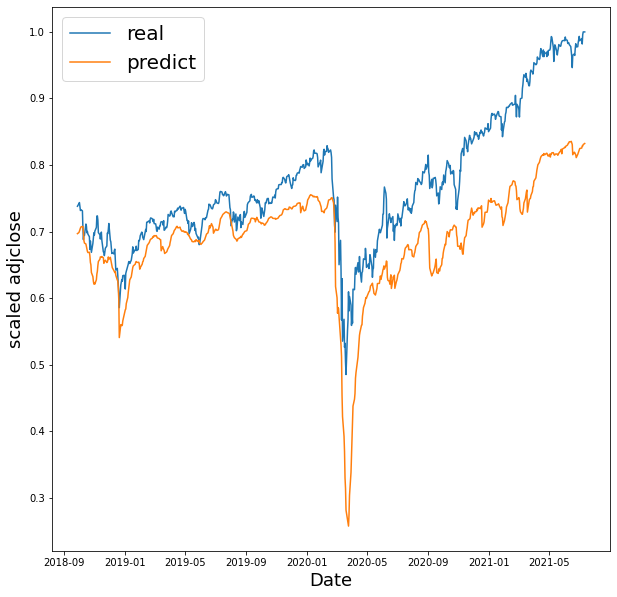

In [ ]:
plot()

In [ ]:
model1_mse = tf.keras.metrics.mean_squared_error(y_test.flatten(), y_pred.flatten())
model1_mse

<tf.Tensor: shape=(), dtype=float32, numpy=0.009257678>

In [ ]:
model2 = Sequential()
model2.add(LSTM(200,return_sequences=True,stateful=True))
model2.add(Dense(1, activation="relu"))

In [ ]:
inp2 = Input((None,3),batch_size=1)
out2 = model2(inp2)

In [ ]:
model2.compile(optimizer='Adam', loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, None, 200)            163200    
_________________________________________________________________
dense_2 (Dense)              (1, None, 1)              201       
Total params: 163,401
Trainable params: 163,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model2.fit(train,validation_data=test,batch_size=1,callbacks=[callback],epochs=10)

Epoch 1/10
      1/Unknown - 0s 122ms/step - loss: 1.4083e-05 - root_mean_squared_error: 0.0038

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


136/136 [==============================] - 25s 187ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947
Epoch 2/10
136/136 [==============================] - 0s 242us/step - loss: 0.0062 - root_mean_squared_error: 0.0790


In [ ]:
y_pred = model2.predict(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


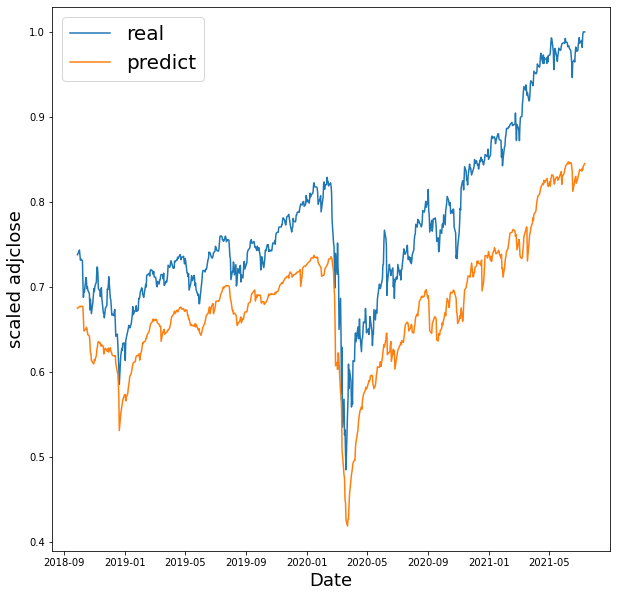

In [ ]:
plot()

In [ ]:
model2_mse = tf.keras.metrics.mean_squared_error(y_test.flatten(), y_pred.flatten())

In [ ]:
model1_mse,model2_mse

(<tf.Tensor: shape=(), dtype=float32, numpy=0.006785344>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0093806535>)